## ELFI Notebook for modelling time series count data

This notebook has been knowingly written to be as descriptive and self-containing as possible. This notebook is written in a story format. First we get some baseline results to see how ELFI works and then try to work it out on a real world dataset.


This is a notebook where I try out a few different things. To summarise I have tried to:

1. See how basic ELFI can be used for modelling highly non linear temporal count data(Ricker stochastic).
2. Add more summary measures in order to reduce the variance of the samples from the original example.
3. Try out both rejection sampling and SMC on this data.
4. Implement the DTW(Dynamic Time Warping) algorithm which can be used for comparing unequal time series.
5. Model a data downloaded from the internet(Geyer data) count data on visits to a shop over 24 hours.
6. Use a simple linear Gaussian model for the data generating process
7. Carry out likelihood free inference by both SMC and Rejection sampling.
8. Carry out some diagnostics to see how variables are stored under the hood and how to use diagnostics to identify the most relevant summary statistics based on minimising the entropy approach.

#### Count Data and Poisson Distribution 

Our case study is on count data. Count data is encountered rather frequently in day-day scenarios. Poisson distribution is one such distribution which can be used to model it. 
@TODO: Write more about Poisson distribution and its important properties.

In [1]:
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats

In [2]:
import GPy
import logging
import wget
import elfi
import pandas
import copy

In [3]:
from collections import OrderedDict, Counter, defaultdict
from functools import partial
from nltk.metrics.distance import edit_distance
from scipy.stats import skew, kurtosis

In [90]:
from sklearn.metrics.pairwise import euclidean_distances, paired_euclidean_distances
from elfi.methods.diagnostics import TwoStageSelection

In [91]:
import seaborn as sns
sns.set(color_codes=True)

In [93]:
seed = 12345

Always good to check the versions for debugging purposes 

In [166]:
print(np.__version__)
print(scipy.__version__)

1.13.1
0.19.1


#### Data Collection
Simple data collection from a url, just to illustrate how to do it properly and formatting the raw data to something usable.
Credits to http://www.stat.umn.edu/geyer/5102/data/ex6-4.txt

Geyer data is about the number of visitors to a shop open for 24 hours. The data was collected for a duration of 14 days, amounting to a total of 336 hours. Therefore there is an inherent daily periodicity associated with the data. For our modelling exercise, we can just sum up the counts for each hour for all the days. It is also possible to model each day seperately, but the summing operation does a smoothing effect, as can be observed from the plots below. 

In [8]:
N_hours= 24
N_days = 14

In [9]:
url = "http://www.stat.umn.edu/geyer/5102/data/ex6-4.txt"
file_txt = wget.download(url)
raw_data = np.loadtxt(fname=file_txt, dtype=np.int32, skiprows=1)
print(raw_data.shape)

(336, 2)


In [10]:
data_dict = {}
hours = raw_data[:,0]
count = raw_data[:,1]
data_dict['hour'] = hours
data_dict['count'] = count
print(data_dict['hour'][:5])

[1 2 3 4 5]


In [11]:
hours_day = data_dict['hour'] 
hours = np.arange(N_hours)
hours_day = (data_dict['hour'] -1) % N_hours +1
data_dict['daily_hours'] = hours_day

In [12]:
counts_cum = np.empty(N_hours)
for i, ind in enumerate(hours_day):
    inds = np.arange(N_days)*N_hours + (ind-1)
    counts_cum[ind-1] = np.sum(count[inds])

In [13]:
data_dict['hour_count'] = counts_cum
Y_geyer = counts_cum
Y_geyer_total = count

 Make sure  that the observations are in the right format, they should have just one row, since while computing summary statistics, the true observation row is vertically stacked with the simulated observations  which is equal to the number of batchsize.

In [14]:
Y_geyer = Y_geyer.flatten().reshape(1,-1)
Y_geyer_total = Y_geyer_total.flatten().reshape(1,-1)

#### Plots for Geyer data

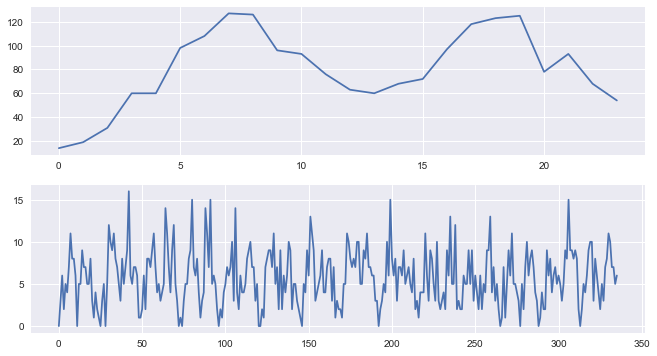

In [15]:
# Plot the observed sequence
figsize=(11, 6)
fig, (ax1, ax2) = plt.subplots(2,1, figsize=figsize)
ax1.plot(Y_geyer.ravel())
ax2.plot(Y_geyer_total.ravel())

In [16]:
# plotting functionality
def plot_prior(Prior, *params, **kwargs):
    distribution =  getattr(scipy.stats, Prior)
    x = np.linspace(distribution.ppf(0.01, *params, **kwargs), distribution.ppf(0.99, *params), 500)
    fig2, ax2 = plt.subplots(1, 1)
    rvs_dist = distribution.rvs(*params, size=500)
    ax2.plot(x, distribution.pdf(x, *params),'r-', lw=5, alpha=0.6, label=str(Prior+'-pdf'))
    ax2.hist(rvs_dist, normed=True, histtype='stepfilled', alpha=0.2)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#### Lets see how the plots for the priors of the parameters look !!

 /u/26/dhakaa1/unix/anaconda2/envs/py35-elfi/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning:The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.


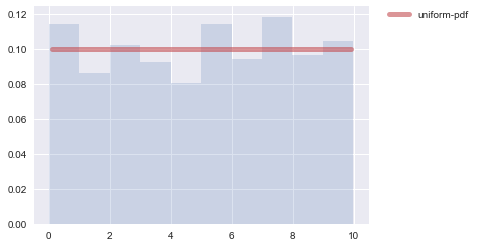

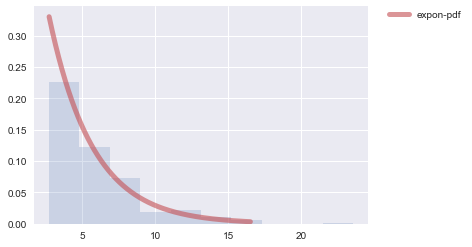

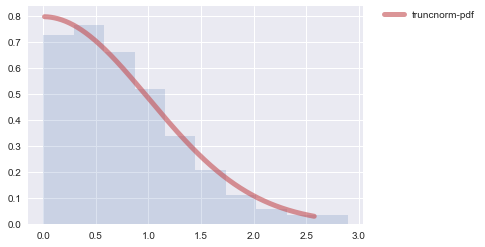

In [17]:
plot_prior('uniform', 0,10)
plot_prior('expon', np.e, 3)
plot_prior('truncnorm', 0, 5)

####  We will try to model this time series with the help of a poisson distribution. We can try to model this with a Ricker series 

Some basics about Poisson distribution

Poisson distribution belongs to the exponential family. It gives a probability dostribution over real positive integers. The Poisson distribution belongs to the exponential family. The sum of random variables which have exponential distribution remain in the exponential family. The sum of Poisson random variables(rvs) is also a Poisson distributed random variable. 
It can be parameterised with the help of intesity($\lambda$) value. 
The probability of observing $k$ events in an interval is given by:
$P(X=k) = \exp ^{-\lambda} \frac{\lambda^k}{k!} $

where $\lambda$ is the average intensity of the events, and should be a positive real valued number.
Poisson distribution just needs one sufficient statistic from the data i.e. $X$. 
The expected value(mean) and variance of a Poisson distributed rv is the same as its intensity rate.
$E(X) = \lambda $
$Var(X) = \lambda $

while the mode(which can only be a positive integer) is:
$\lceil \lambda \rceil -1, \lfloor \lambda \rfloor$

#### RIcker's Model

### Specify the model(Simulator) for generating synthetic obervations

#### Summary Statistics



For "non-standard" and "application-specific" statistics of the data, we define some additional statistics which can be used further. Some of these for instance could be:
1. Number of zeros in a sequence
2. Number of large numbers in a sequence
3. Autocovariance: $\sum_{i=2}^{n} \frac{Y_{i}Y_{i-1}}{n}$


These measures are a bit adhoc, in the sense that the user has to see the data to determine what statistics should be used. For example, if the data does not have any zeros at all, the first measure is not at all useful.

In [18]:
class SummaryStatsEx(object):
    def num_zeros(X):
        val = np.sum(X==0, axis=1)
        return val
    
    # rows correspond to the amount of batch_size if I am not wrong, and columns correspond to the simulated data..     
    def num_large(X, val=100):
        val = np.sum(X>100, axis=1)
        return val
    
    def autocov(X, lag=1):
        val = np.mean(X[:,lag:]*X[:,:-lag], axis=1)
        return val
    
    def identity(X):
        return X

#### Distance 

This module will have all distance based measures for computing the distance("difference") between observed data and simulated data. The measures are listed as:

1. Root Mean Squared Error : $\sqrt(\sum_{i} (Y_i^s - Y_i^o)^2) $
2. Chi-Squared Error: $\sum_{i} (Y_i^s - Y_i^o)^2 / Y^o_i  $
3. Mean absolute Error: $\sum_{i} |(Y_i^s - Y_i^o)| $
4. Normalised Mean absolute Error: $\sum_{i} |(Y_i^s - Y_i^o)|/Y_i^o $

The above measures only measure element wise difference without taking into account the temporal nature of the data.  The methods given below also take that into account. It could be a worthwhile exercise to compare these two different classes of distance measures.

One such measure is DTW(Dynamic Time Warping).

DTW finds the best match between any two sequences of symbols by finding a path through the grid which minimises the total distance between them. This is especially helpful if there is a small offset or a random noise insertion/deletion between two similar strings. We go from left to right in both strings taking one step at a time. One step could mean an insertion or a deletion or no operation. For example, the difference between "stiff" and "satiff" would be just 1, while if we do a pairwise difference, it would be 4. We will use this for our notebook.


Below we show a small illustration for DTW and code in Python for it.

In [19]:
def DTW(X, Y, cost_fn):
    '''
 
    Dynamic Time Warping algorithm.
    Parameters
    ----------
    X: sequence of observations: should be a list of numerals or string
    Y: second sequence of observations: should be a list of numerals or string
    cost_fn: could be anyone of the pair-wise distances, for numbers it could be 'euclidean' or 'manhattan', 
    for string literals it could be edit_distance.
    Returns
    -------
    D1: cost matrix 
    
    '''
    N = len(X)
    M = len(Y)
    X1 = X.copy()
    Y1 = Y.copy()
    
    
    D0 = np.zeros((N+1,M+1))
    large_num = 1000
    D0[1:,0]= large_num
    D0[0,1:] = large_num
    
    D1 = D0[1:,1:]
    for i in np.arange(N):
        for j in np.arange(M):
            if not isinstance(X[0], str):
                a = X[i].copy()
                b = Y[j].copy()
                a = a.reshape(-1,1)
                b = b.reshape(-1,1)
                D1[i,j] = cost_fn(a, b)
            else:
                D1[i,j] = cost_fn(X[i], Y[j])
                
    
    D2 = D1.copy()
    for i in range(N):
        for j in range(M):
            min_val = np.min(np.array([D0[i+1,j], D0[i,j+1], D0[i,j]]))
            D1[i,j] += min_val
    return D1[-1,-1]/np.sum(D1.shape), D2, D1


[[  0.   3.   8.  12.  15.  18.  22.]
 [  5.   4.   8.  14.  17.  19.  23.]
 [  9.   7.   6.  11.  15.  18.  22.]
 [ 12.  10.  11.  10.  12.  15.  18.]
 [ 16.  12.  15.  14.  12.  16.  18.]
 [ 21.  17.  18.  19.  17.  17.  21.]
 [ 24.  19.  22.  22.  17.  20.  20.]
 [ 27.  22.  23.  26.  20.  17.  20.]
 [ 31.  25.  27.  26.  23.  20.  17.]]
[[ 0.  3.  5.  4.  3.  3.  4.]
 [ 5.  4.  5.  6.  5.  4.  5.]
 [ 4.  3.  2.  5.  4.  3.  4.]
 [ 3.  3.  5.  4.  2.  3.  3.]
 [ 4.  2.  5.  4.  2.  4.  3.]
 [ 5.  5.  6.  5.  5.  5.  5.]
 [ 3.  2.  5.  4.  0.  3.  3.]
 [ 3.  3.  4.  4.  3.  0.  3.]
 [ 4.  3.  5.  3.  3.  3.  0.]]


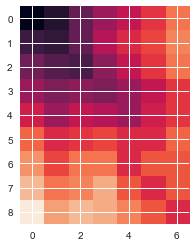

In [20]:
Xstr = ['Jack', 'hardly', 'plays', 'and',  'is', 'quite', 'a',   'lazy', 'boy']
Ystr = ['Jack', 'has',    'always', 'been', 'a', 'lazy', 'boy']
dist, cost, acc = DTW(Xstr,Ystr, edit_distance)
print(acc)
print(cost)
plt.imshow(acc)
plt.show()
# print(dist)

In [21]:
poisson_noise = scipy.stats.poisson.rvs(0.4, Y_geyer.size)
Y_geyer_noise = Y_geyer + poisson_noise
a = np.int64(Y_geyer.copy().reshape(-1,1))
b = np.int64(Y_geyer_noise.copy().reshape(-1,1))

dist1, cost1, acc1 = DTW(a, b, euclidean_distances)


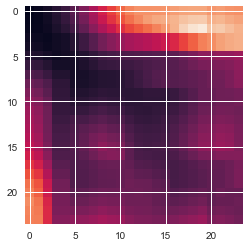

8.72916666667


In [22]:
plt.imshow(acc1)
plt.show()
print(dist1)

In [24]:
# Module for storing different summary and distance measures.
class DistanceMeasures(object):
    """
    Each set of observation corresponds to one row of the matrix.
    Collection of all pairswise-distance measures.
    The true observations should be the first row 
    and the simulated observations the rest.
    """
    
    # Chi-squared Error !     
    def chi_squared(*simulated, observed):
        simulated = np.column_stack(simulated)
        observed = np.column_stack(observed)
#         simulated = np.vstack(simulated)
#         observed = np.vstack(observed)
        d = np.sum((simulated - observed)**2/observed, axis=1)
        return d

    # Root Mean Squared Error!
    def RMSE(*simulated, observed):
        simulated = np.column_stack(simulated)
        observed = np.column_stack(observed)
#         simulated = np.vstack(simulated)
#         observed = vstack(observed)
#         d = np.sum((simulated - observed)**2, axis=0)
        d = np.sum((simulated - observed)**2, axis=1)
        return d

    # Mean Absolute Error !
    def MAE(*simulated, observed):
        simulated = np.column_stack(simulated)
        observed = np.column_stack(observed)
#         simulated = np.vstack(simulated)
#         observed = np.vstack(observed)
#         d = np.sum(np.abs((simulated - observed)), axis=0)
        d = np.sum(np.abs((simulated - observed)), axis=1)
        return d
    
    def DTW(observed, simulated):
        simulated = np.asarray(simulated).reshape(-1,1)
        observed = np.asarray(simulated).reshape(-1,1)
        d, _, _ = DTW(simulated, observed)
        return d


####  Ricker Model
The Ricker model used in ecology has also been used in publications related to ABC, The stochastic version is a nonlinear autoregeressive model.

$\log N^{t} =  \log r + \log N^{(t-1)} -N^{(t-1)} +\sigma e^{(t)} $

In [25]:
# model simulator for ricker's model:
def ricker(log_rate, stock_init=1., n_obs=100, batch_size=1, random_state=None):
    """
    Generates observations from Rickers model.
    This is the non stochastic version.
    """
    random_state = random_state or np.random
    stock = np.empty((batch_size, n_obs))
    stock[:,0] = stock_init
    for i in range(1, n_obs):
        stock[:,i] = stock[:,i-1]*np.exp(log_rate - stock[:,i-1])
    
    return stock


# stochastic Ricker
def ricker_stochastic(log_rate, std, scale=1, stock_init=1., n_obs=100, batch_size=1, random_state=None):
    """
    This function will help us generate stochastic observations from a Ricker model.
    The Ricker model is nonlinear autoregressive model, with negative correlation 
    The latent time series denoted by N is given as:
    log(N[i]) = logr + logN[i-1] - N[i-1] + sigma*e[i]            i = 1,..., n     N[0]=0
    
    where logr is the log growth rate, e[i] is a Gaussian random variable.
    
    The obervation model is assumed to be Poisson distributed with mean given as: pN[i]
    
    Y[i]|N[i],p  ~ Poisson(p*N[i]) 
    
    where p is the scaling parameter.
    
    Parameters
    ------------------
    log_rate: logr
    sigma: 
    
    
    """
    random_state = random_state or np.random
    stock_obs = np.empty((batch_size, n_obs))
    stock_prev = stock_init
    stock_list = np.empty((batch_size, n_obs))
    stock_list[:,0] = stock_init

    for i in range(1, n_obs):
        stock = stock_prev * np.exp(log_rate - stock_prev + std*random_state.randn(batch_size))
        stock_prev = stock
        stock_list[:,i] = stock
        stock_obs[:,i] = random_state.poisson(scale*stock, batch_size)
    
    return stock_obs

In [26]:
# log X(t) = w1*logX(t-1) - w2*(X(t-1) - X(t-2)) + w3*eps.
# eps : N(0,1)

def model_trial2(log_rate, std, scale=1, stock_init=1., n_obs=100, batch_size=1, random_state=None):
    random_state = random_state or np.random
    stock_obs = np.empty((batch_size, n_obs))
    stock_prev = stock_init
    stock = np.empty((batch_size, n_obs))
    stock_list[:,0] = stock_init
    
    w1 = random_state.randn(batch_size, 4)
    stock_prev_prev = 0.
#     w2 = random_state.randn(batch_size, n_obs+2, 4)

    for i in range(1, n_obs):
        log_stock = w1[:,0]*log_rate + w1[:,1]*np.log(stock_prev) - w1[:,2]*(stock_prev - stock_prev_prev) + \
        w1[:,3]*std*random_state.randn(batch_size)
        stock = np.exp(log_stock)
        stock_prev = stock
        stock_prev_prev = stock_prev
        stock_list[:,i] = stock
        stock_obs[:,i] = random_state.poisson(np.exp(scale*stock), batch_size)
    
    return stock_obs

####  Make a model in ELFI for Ricker model.

In addition to the summary measures given in the example, we add two more measures: skewness and kurtosis(third-order and fourth-order moments) and a measure for how many numbers are big 

In [27]:
#  this function uses the partial functionality of functools which is very cool, 

def get_ricker_model(fn, y_obs=None, n_obs=100, true_params=None, seed_obs=None, stochastic=True, higher_order=True):
    if stochastic:
        simulator = partial(ricker_stochastic, n_obs=n_obs)
        if true_params is None:
            true_params = [3.8, 0.3, 10.]
    else:
        simulator = partial(ricker, n_obs=n_obs)
        if true_params is None:
            true_params = [3.8]
    
    m = elfi.ElfiModel()
    if y_obs is None:
        y_obs = simulator(*true_params, n_obs=n_obs, random_state=np.random.RandomState(seed_obs))
    else:
        n_obs = np.asanyarray(y_obs).size
    sim_fn = partial(simulator, n_obs=n_obs)
    sumstats = []
    
    if stochastic:
        # full stochastic model here ..         
        elfi.Prior(stats.expon, np.e, 2, model=m, name='t1')
        elfi.Prior(stats.truncnorm, 0, 5, model=m, name='t2')
        elfi.Prior(stats.uniform, 0, 100, model=m, name='t3')
        elfi.Simulator(sim_fn, m['t1'], m['t2'], m['t3'], observed=y_obs, name='Ricker')
        sumstats.append(elfi.Summary(partial(np.mean, axis=1), m['Ricker'], name='Mean'))
        sumstats.append(elfi.Summary(partial(np.var, axis=1), m['Ricker'], name='Var'))
        sumstats.append(elfi.Summary(partial(skew, axis=1), m['Ricker'], name='skew'))
        sumstats.append(elfi.Summary(partial(kurtosis, axis=1), m['Ricker'], name='kurt'))
        sumstats.append(elfi.Summary(SummaryStatsEx.num_zeros, m['Ricker'], name='num_zeros'))
        sumstats.append(elfi.Summary(SummaryStatsEx.num_large, m['Ricker'], name='num_large'))
        elfi.Discrepancy(DistanceMeasures.chi_squared, *sumstats, name='d')
    else:
        # simple deterministic case here ..         
        elfi.Prior(stats.expon, np.e, model=m, name='t1')
        elfi.Simulator(sim_fn, m['t1'], observed=y_obs, name='Ricker')
        sumstats.append(elfi.Summary(partial(np.mean, axis=1), m['Ricker'], name='Mean'))
        elfi.Distance('euclidean', *sumstats, name='d')
    return m
    

In [28]:
def get_ricker_model_dtw(fn, y_obs=None, n_obs=100, true_params=None, seed_obs=None,higher_order=True):
    simulator = partial(ricker_stochastic, n_obs=n_obs)
    
    m = elfi.ElfiModel()
    if y_obs is None:
        y_obs = simulator(*true_params, n_obs=n_obs, random_state=np.random.RandomState(seed_obs))
    else:
        n_obs = np.asanyarray(y_obs).size
    sim_fn = partial(simulator, n_obs=n_obs)
    sumstats = []

    elfi.Prior(stats.expon, np.e, 2, model=m, name='t1')
    elfi.Prior(stats.truncnorm, 0, 5, model=m, name='t2')
    elfi.Prior(stats.uniform, 0, 100, model=m, name='t3')
    elfi.Simulator(sim_fn, m['t1'], m['t2'], m['t3'], observed=y_obs, name='Ricker')
    sumstats.append(elfi.Summary(SummaryStatsEx.identity, m['Ricker'], name='identity'))
#   elfi.Discrepancy(DistanceMeasures.chi_squared, *sumstats, name='d')
    elfi.Distance(partial(DistanceMeasures.DTW, observed=y_obs), *sumstats, name='d')
    return m


####  Generate artificial observations from the Ricker model itself using some known parameter values.
Following this, generate the full graphical model, which is the same as given in the ELFI examples.

In [29]:
true_params = [3.8, 0.3, 10.]
n_obs = 100
seed_obs = 1234
Y1 = ricker_stochastic(*true_params, n_obs=n_obs, random_state=np.random.RandomState(seed_obs))

39.76
61.1692307692
30.0


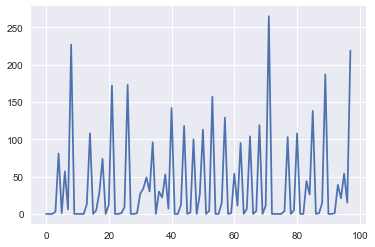

In [30]:
plt.plot(Y1.ravel()[2:])
print(np.mean(Y1))
print(np.mean(Y1[Y1>0]))
print(np.median(Y1[Y1>0]))

In [97]:
m = get_ricker_model(ricker_stochastic, y_obs=Y1)

Plot the Ricker model

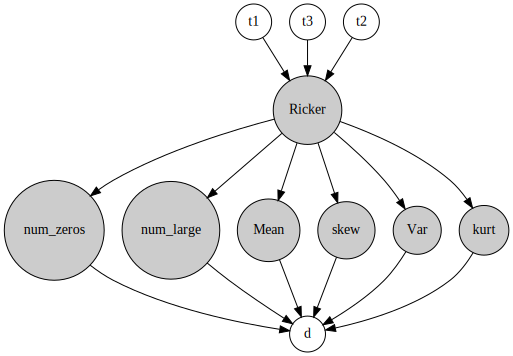

In [98]:
elfi.draw(m)

In [99]:
m_rej_inf = elfi.Rejection(m, m['d'], batch_size=8)

In [100]:
result = m_rej_inf.sample(500)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f508a933588>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f508a92f2e8>], dtype=object)

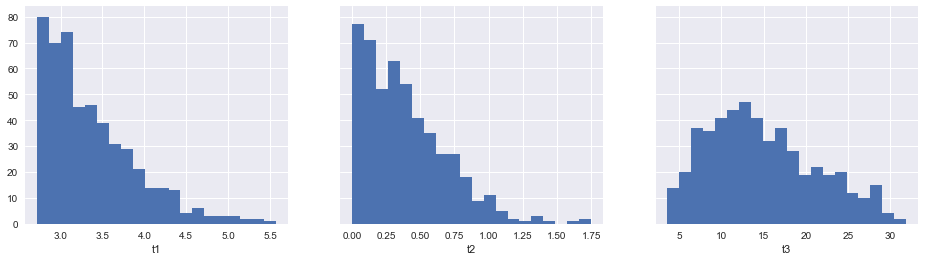

In [101]:
result.plot_marginals()
# result.plot_pairs()

In [37]:
m2_ricker = get_ricker_model(ricker, y_obs=Y1, stochastic=False)

###  Plot for non-stochastic  Ricker model

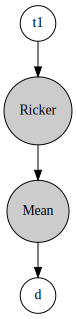

In [38]:
elfi.draw(m2_ricker)

In [39]:
# flush all python objects here to avoid namespace collapse ..
if m:
    del m
    del m_rej_inf
    del result

#### Our Note/Observations from  the plots above.
In the plots above, we basically just replicated the example from ELFI, nothing original until here ..., but this is atleast a good base to start with. Also the above plots are good, and demonstrate the rejection sampling gave satifactory results with the modes of the plots close to the original true values of the parameters. 

In [40]:
print(Y_geyer.shape)

(1, 24)


In [41]:
m3 = get_ricker_model(ricker_stochastic, y_obs=Y_geyer)

In [42]:
pool = elfi.OutputPool([m3['t1'], m3['t2'], m3['t3'], m3['Ricker'], m3['Mean'], m3['Var']])
# pool2 = elfi.ArrayPool([m3['t1'], m3['t2'], m3['t3'], m3['Ricker']])

In [43]:
m3_rej = elfi.Rejection(m3, m3['d'], batch_size=5, pool=pool)
# m3_rej = elfi.Rejection(m3, m3['d'], batch_size=10, pool=pool2)

In [44]:
N_samples = 400
result_geyer = m3_rej.sample(N_samples)

 /u/26/dhakaa1/unix/anaconda2/envs/py35-elfi/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning:divide by zero encountered in true_divide
 /u/26/dhakaa1/unix/anaconda2/envs/py35-elfi/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning:invalid value encountered in true_divide


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5090191fd0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f509013de48>], dtype=object)

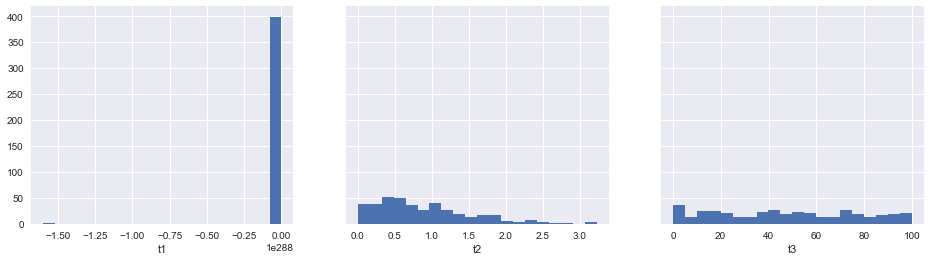

In [60]:
result_geyer.plot_marginals()

We also try an alternative model to the above Ricker model which we used for modelling the Geyer data.

The above plots are not so encouraging because they show that the scale parameter for the Poisson process is close to 0, this might mean that we should use some alternate model for the latent stochastic time series, and our modelling assumptions are not really suitable for this dataset. Also, if we carefully look at the plots for the original Ricker model simulated abservations and our hourly observations, they exhibit different behaviours. While the original observations have a very high oscillatory behaviour explaining the negative covariances between subsequent observations, the Geyer observations have a much more smooth pattern and positive correlations.  We try a different model then.

In [62]:
result_geyer.samples['t1'].std()


 /u/26/dhakaa1/unix/anaconda2/envs/py35-elfi/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning:overflow encountered in multiply


inf

### Diagnostics
Lets have a look into the inside dynamics of the model and simulator. Some inbuilt methods can be used to see internals like samples, thresholds etc. It is also possible to view them 

In [63]:
print(m3)

In [64]:
print(m3.parameter_names)


['t1', 't2', 't3']


In [65]:
m3.get_state('t1')

{'_class': elfi.model.elfi_model.Prior,
 '_operation': functools.partial(<function rvs_from_distribution at 0x7f509dfa0378>, size=None, distribution=<scipy.stats._continuous_distns.expon_gen object at 0x7f50a02f0780>),
 '_parameter': True,
 '_stochastic': True,
 '_uses_batch_size': True,
 'distribution': <scipy.stats._continuous_distns.expon_gen at 0x7f50a02f0780>,
 'size': None}

In [66]:
print(m3.get_state('d'))

{'_operation': <function DistanceMeasures.chi_squared at 0x7f50905dcbf8>, '_uses_observed': True, '_class': <class 'elfi.model.elfi_model.Discrepancy'>}


In [67]:
arraypool = elfi.ArrayPool(['t1', 't2', 'Y', 'd'])
# rej = elfi.Rejection(d, pool=arraypool)

#### Our Note/Observations from  the plots above.

We also try an alternative model to the above Ricker model which we used for modelling the Geyer data.



#### Proposed Model

Here, we propose a model which can handle 2nd degree interactions, unless we have some prior information about the data geenrating process, it could be hard to come up with a suitable model.
Lets have a linear Gaussian autoregressive model.

$ X(t) = a.X(t-1) + b.X(t-2) + c.\epsilon  \\$

The observation model can then be defined as a gaussian with the mean equal to latent value at that time instance.
The link function is generally taken to be an exponential function. But here, we use a simpler squaring function.
The motivation for this model is the smooth nature of the plot of the observation data. As the observations are positive integers, the values are rounded off to the nearest integer.

$ Y(t) = N(g(X(t)), 1)$
where $g(.)$ is a link function.

$ Y(t) = N(dX(t)^2, 1)$
where $d$ is a scaling constant.


In [68]:
def model_2_degree(a, b, c, d=1, stock_init=0., n_obs=100, batch_size=1, random_state=None):
    random_state = random_state or np.random
    stock_obs = np.empty((batch_size, n_obs))
    stock_prev = stock_init
    stock_list = np.empty((batch_size, n_obs))
    stock_list[:,0] = stock_init
    
    w1 = random_state.randn(batch_size, 4)
    stock_prev_prev = 0.
#     w2 = random_state.randn(batch_size, n_obs+2, 4)

    for i in range(1, n_obs):
        stock = a*stock_prev + b*stock_prev_prev + c*random_state.randn(batch_size)
        stock_prev = stock
        stock_prev_prev = stock_prev
        stock_list[:,i] = stock
        
        stock_obs[:,i] = np.rint(random_state.normal((d*stock)**2, batch_size))
#         stock_obs[:,i] = random_state.poisson((d*stock)**2, batch_size)
    
    return stock_obs

In [69]:
def get_2degree_model(y_obs, seed_obs=None, stochastic=True, higher_order=True):
    n_obs = y_obs.size 

    simulator = partial(model_2_degree, n_obs=n_obs)
    m = elfi.ElfiModel()
    sim_fn = partial(simulator, n_obs=n_obs)
    sumstats = []
    elfi.Prior(stats.truncnorm, 0, 10, model=m, name='a')
    elfi.Prior(stats.norm, 0, 10, model=m, name='b')
    elfi.Prior(stats.norm, 0, 5, model=m, name='c')
    elfi.Prior(stats.uniform, 0.0001, 4, model=m, name='d')
    elfi.Simulator(sim_fn, m['a'], m['b'], m['c'], m['d'], observed=y_obs, name='2degree')
    sumstats.append(elfi.Summary(partial(np.mean, axis=1), m['2degree'], name='Mean'))
    sumstats.append(elfi.Summary(partial(np.var, axis=1), m['2degree'], name='Var'))
    sumstats.append(elfi.Summary(partial(skew, axis=1), m['2degree'], name='skew'))
    sumstats.append(elfi.Summary(partial(kurtosis, axis=1), m['2degree'], name='kurt'))
    elfi.Discrepancy(DistanceMeasures.chi_squared, *sumstats, name='dist')
    return m
    

In [70]:
m_2deg = get_2degree_model(y_obs=Y_geyer)

Plot the model(each latent observation is a weighted sum of the previous two observations.)

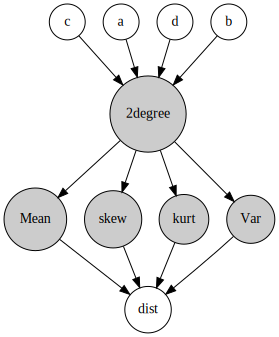

In [71]:
elfi.draw(m_2deg)

In [72]:
m_2deg_inf = elfi.Rejection(m_2deg, m_2deg['dist'], batch_size=8)

In [73]:
N_samples = 1000
result_geyer_m2= m_2deg_inf.sample(N_samples)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f50900944a8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f509005e7f0>], dtype=object)

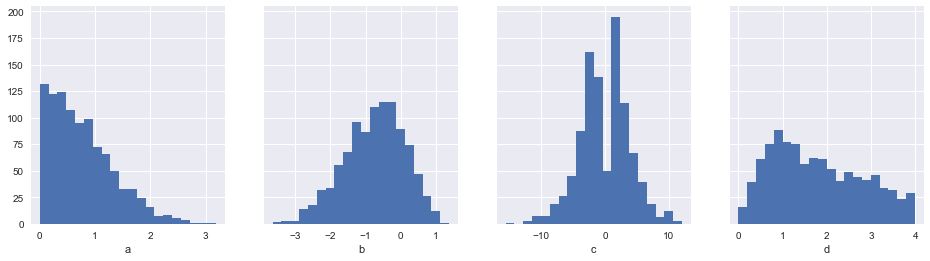

In [74]:
result_geyer_m2.plot_marginals()

In [76]:
print(result_geyer_m2.samples['a'].mean())
print(result_geyer_m2.samples['b'].mean())

print(result_geyer_m2.samples['d'].mean())

0.769447329536
-0.759499297534
1.78765582317


In [78]:
N = 1000
smc = elfi.SMC(m_2deg['dist'], batch_size=20000)

In [81]:
# t = 0.1
N = 1000
thresholds = [.5, .25, .1]
result_geyer_smc = smc.sample(N, thresholds = thresholds)

 /u/26/dhakaa1/unix/anaconda2/envs/py35-elfi/lib/python3.5/site-packages/scipy/stats/stats.py:934: RuntimeWarning:overflow encountered in square
 /u/26/dhakaa1/unix/anaconda2/envs/py35-elfi/lib/python3.5/site-packages/scipy/stats/stats.py:936: RuntimeWarning:overflow encountered in multiply
 /u/26/dhakaa1/unix/anaconda2/envs/py35-elfi/lib/python3.5/site-packages/scipy/stats/stats.py:1031: RuntimeWarning:overflow encountered in power
 /u/26/dhakaa1/unix/anaconda2/envs/py35-elfi/lib/python3.5/site-packages/scipy/stats/stats.py:1031: RuntimeWarning:invalid value encountered in true_divide
 /u/26/dhakaa1/unix/anaconda2/envs/py35-elfi/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning:overflow encountered in square
 /u/26/dhakaa1/unix/anaconda2/envs/py35-elfi/lib/python3.5/site-packages/elfi/methods/parameter_inference.py:563: RuntimeWarning:invalid value encountered in less_equal
 /u/26/dhakaa1/unix/anaconda2/envs/py35-elfi/lib/python3.5/site-packages/numpy/core/_methods.

In [82]:
print(result_geyer_smc.samples['a'].mean())
print(result_geyer_smc.samples['b'].mean())

print(result_geyer_smc.samples['d'].mean())

1.34185360397
11.5713095153
2.36235255385


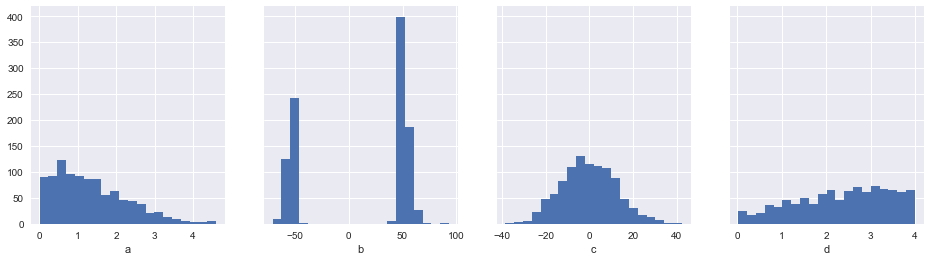

In [83]:
result_geyer_smc.plot_marginals()

###  Diagnostics

Lets come back to the original Ricker model and data and see if the additional summary measures are really helpful or not. Using the diagnostics tool, we can pin point the summary stats, which have the biggest role in obtaining data closer to the true observations.

In [103]:
theta_acc = result.samples_array

In [105]:
print(theta_acc.shape)

(500, 3)


In [115]:
# simulator = elfi.Simulator(fn_simulator, prior_t1, prior_t2, observed=y_obs)

simulator = partial(ricker_stochastic, n_obs=n_obs)
sim_fn = partial(simulator, n_obs=n_obs)
true_params = [3.8, 0.3, 10.]

y_obs = simulator(*true_params, n_obs=n_obs, random_state=np.random.RandomState(seed_obs))
m = elfi.ElfiModel()
elfi.Prior(stats.expon, np.e, 2, model=m, name='t1')
elfi.Prior(stats.truncnorm, 0, 5, model=m, name='t2')
elfi.Prior(stats.uniform, 0, 100, model=m, name='t3')
sim1 = elfi.Simulator(sim_fn, m['t1'], m['t2'], m['t3'], observed=y_obs, name='Rickersto')

For some reason which I dont fully understand, writing skew function as skew does not work, because I think it is already in the namespace, wrappint it with a function with a different name does the trick .

In [167]:
def ss_mean(x):
    return np.mean(x, axis=1)

def ss_var(x):
    return np.var(x, axis=1)

def ss_skew(x):
    return stats.skew(x, axis=1)

def ss_kurtosis(x):
    return stats.kurtosis(x, axis=1)

def num_zeros(x):
    return np.sum(x==0, axis=1)

def num_large(x, val=25):
    return np.sum(x > val, axis=1)


In [180]:
list_ss = []
list_ss.append(ss_mean)
list_ss.append(ss_var)
list_ss.append(num_zeros)
list_ss.append(num_large)
list_ss.append(ss_skew)
list_ss.append(ss_kurtosis)

In [170]:
print(list_ss)

[<function ss_mean at 0x7f508a9f4c80>, <function ss_var at 0x7f508a9f47b8>, <function num_zeros at 0x7f508a9d7f28>, <function num_large at 0x7f508a890a60>, <function ss_skew at 0x7f508a989ea0>, <function ss_kurtosis at 0x7f508a9891e0>]


In [171]:
diagnostics = TwoStageSelection(sim1, 'euclidean', list_ss=list_ss, seed=seed)

In [172]:
set_ss_2stage = diagnostics.run(n_sim=100000, batch_size=10000)

We observse that the mean function of the data and the simple function which calculates how many numbers are large in the dataset are the most influential summary stats in this study.

In [175]:
print(set_ss_2stage)

(<function ss_mean at 0x7f508a9f4c80>, <function num_large at 0x7f508a890a60>)


In [188]:
list_ss_geyer = copy.deepcopy(list_ss)

In [189]:
print(list_ss)
print(list_ss_geyer)

[<function ss_mean at 0x7f508a9f4c80>, <function ss_var at 0x7f508a9f47b8>, <function num_zeros at 0x7f508a9d7f28>, <function num_large at 0x7f508a890a60>, <function ss_skew at 0x7f508a989ea0>, <function ss_kurtosis at 0x7f508a9891e0>]
[<function ss_mean at 0x7f508a9f4c80>, <function ss_var at 0x7f508a9f47b8>, <function num_zeros at 0x7f508a9d7f28>, <function num_large at 0x7f508a890a60>, <function ss_skew at 0x7f508a989ea0>, <function ss_kurtosis at 0x7f508a9891e0>]


In [191]:
print(Y_geyer)
n_obs = Y_geyer.size
print(n_obs)

[[  14.   19.   31.   60.   60.   98.  108.  127.  126.   96.   93.   76.
    63.   60.   68.   72.   97.  118.  123.  125.   78.   93.   68.   54.]]
24


####  Diagnostics for the Geyer data and model. 

In [192]:
sim_fn2 = partial(model_2_degree, n_obs=n_obs)
m = elfi.ElfiModel()
# sim_fn2 = partial(simulator, n_obs=n_obs)

elfi.Prior(stats.truncnorm, 0, 10, model=m, name='a')
elfi.Prior(stats.norm, 0, 10, model=m, name='b')
elfi.Prior(stats.norm, 0, 5, model=m, name='c')
elfi.Prior(stats.uniform, 0.0001, 4, model=m, name='d')
sim_geyer = elfi.Simulator(sim_fn2, m['a'], m['b'], m['c'], m['d'], observed=Y_geyer, name='2degree1')

In [193]:
diagnostics_geyer = TwoStageSelection(sim_geyer, 'euclidean', list_ss=list_ss_geyer, seed=seed)

In [194]:
set_ss_2stage_geyer = diagnostics.run(n_sim=100000, batch_size=10000)

In [195]:
print(set_ss_2stage_geyer)

(<function ss_mean at 0x7f508a9f4c80>, <function num_large at 0x7f508a890a60>)


### References
1. Michael U. Gutmann,Jukka Corander. Bayesian Optimization for Likelihood-Free Inference of Simulator-Based Statistical Models  Journal of Machine Learning Research- JMLR 16 2015
2. Jean-Michel Marin, Pierre Pudlo, Christian P. Robert and Robin J. Ryder. Approximate Bayesian computational methods. Statistics and Computing 2011.
3. Jarno Lintusaari, Henri Vuollekoski, Antti Kangasrääsiö, Kusti Skytén, Marko Järvenpää, Michael Gutmann, Aki Vehtari, Jukka Corander and Samuel Kaski. ELFI: Engine for Likelihood Free Inference
4. Jarno Lintusaari, Michael Gutmann, Ritabratta Dutta, Samuel Kaski and Jukka Corander
Fundamentals and Recent Developments in Approximate Bayesian Computation. Oxford University Press  2017
5. Nunes, M. A., & Balding, D. J. (2010). On optimal selection of summary statistics for approximate Bayesian computation. Statistical applications in genetics and molecular biology, 9(1).
6. Blum, M. G., Nunes, M. A., Prangle, D., & Sisson, S. A. (2013). A comparative review of dimension reduction methods in approximate Bayesian computation. Statistical Science, 28(2), 189-208